# Notes:

 - There are 4 channels:     
        - Ch2-T1 - red   
        - ChS2-T2 - yellow   
        - ChS1-T3  - green   
        - Ch1-T4 - cyan    

- There should be fewer than 200 cells per image, as few as 4.

- Cells should exists for 1 or combinations 2 colors (not 3 or 4) - lineages will share there colors

- We expect a color combination becomes the dominant lineage 

- Need to check same resolution and same area on the plate

- Only compare same group (control) on same day
"""

In [1]:
import pandas as pd
import numpy as np
import os
from math import sqrt
import numba
from importlib import reload
from itertools import combinations
from scipy.spatial import distance_matrix

import skimage
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.morphology import reconstruction
from skimage import color, morphology
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# locals
import blob_detection as _blob
import utils as _tools

In [2]:
%time 
reload(_tools)

exp = _tools.FileLoader("../test_data/")
exp.df.head()

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 7.39 µs


filename      group  day  channel channel_color  \
0     Control Day 0_Ch2-T1.png    Control    0   Ch2-T1           red   
1   Lysozyme Day 6_ChS1-T3.png   Lysozyme    6  ChS1-T3          blue   
2   Control Day 10_ChS1-T3.png    Control   10  ChS1-T3          blue   
3  Ovalbumin Day 3_ChS1-T3.png  Ovalbumin    3  ChS1-T3          blue   
4   Ovalbumin Day 5_Ch1-T4.png  Ovalbumin    5   Ch1-T4          cyan   

                                               image  
0  [[[0, 0, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3  [[[0, 0, 0], [0, 0, 0], [0, 2, 0], [0, 0, 0], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

In [3]:
"""
clear the figure folder each time
"""
_tools.clear_figs()

Cleared: figs/*


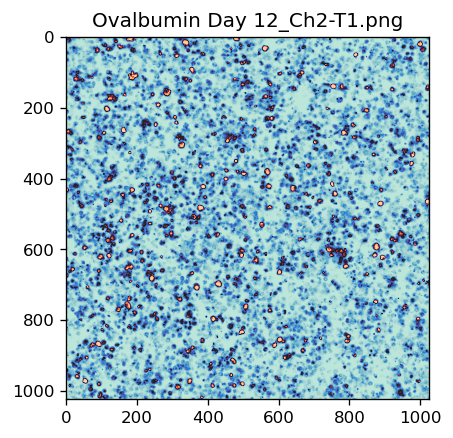

In [4]:
matplotlib.rcParams['figure.dpi'] = 120

plt.axis_off = True
rand_img = np.random.randint(0, len(exp.df) - 1)
plt.imshow(rgb2gray(exp.df.iloc[rand_img]['image']), cmap='icefire')
plt.title(str(exp.df.iloc[rand_img]['filename']))

plt.savefig("figs/_example_image_icefire.png")


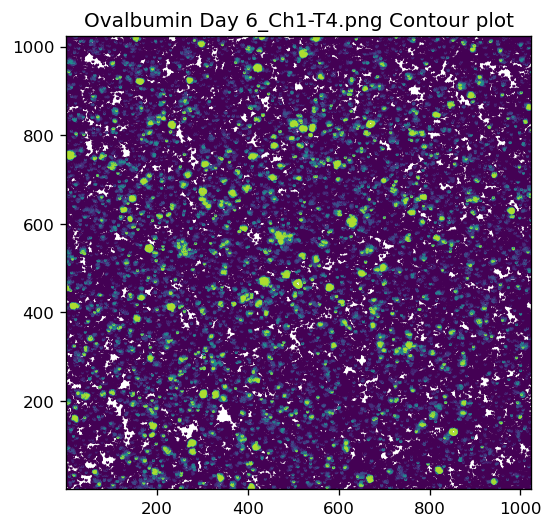

Saved: figs/Ovalbumin Day 6_Ch1-T4.png_contour.png


<Figure size 720x480 with 0 Axes>

In [5]:
"""
what do contour plots look like
"""

reload(_blob)

sample = exp.df.sample(1)

for idx, row in sample.iterrows():
    _blob.plot_contour(row)

In [6]:
# exp.df['channel'].value_counts()
exp.df.head()

# exp.df['channel'].unique()

filename      group  day  channel channel_color  \
0     Control Day 0_Ch2-T1.png    Control    0   Ch2-T1           red   
1   Lysozyme Day 6_ChS1-T3.png   Lysozyme    6  ChS1-T3          blue   
2   Control Day 10_ChS1-T3.png    Control   10  ChS1-T3          blue   
3  Ovalbumin Day 3_ChS1-T3.png  Ovalbumin    3  ChS1-T3          blue   
4   Ovalbumin Day 5_Ch1-T4.png  Ovalbumin    5   Ch1-T4          cyan   

                                               image  
0  [[[0, 0, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3  [[[0, 0, 0], [0, 0, 0], [0, 2, 0], [0, 0, 0], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

Saved: figs/Ovalbumin Day 9_ChS1-T3.png.png
Saved: figs/Lysozyme Day 4_Ch2-T1.png.png
Saved: figs/Ovalbumin Day 1_Ch2-T1.png.png
Saved: figs/Lysozyme Day 9_Ch2-T1.png.png


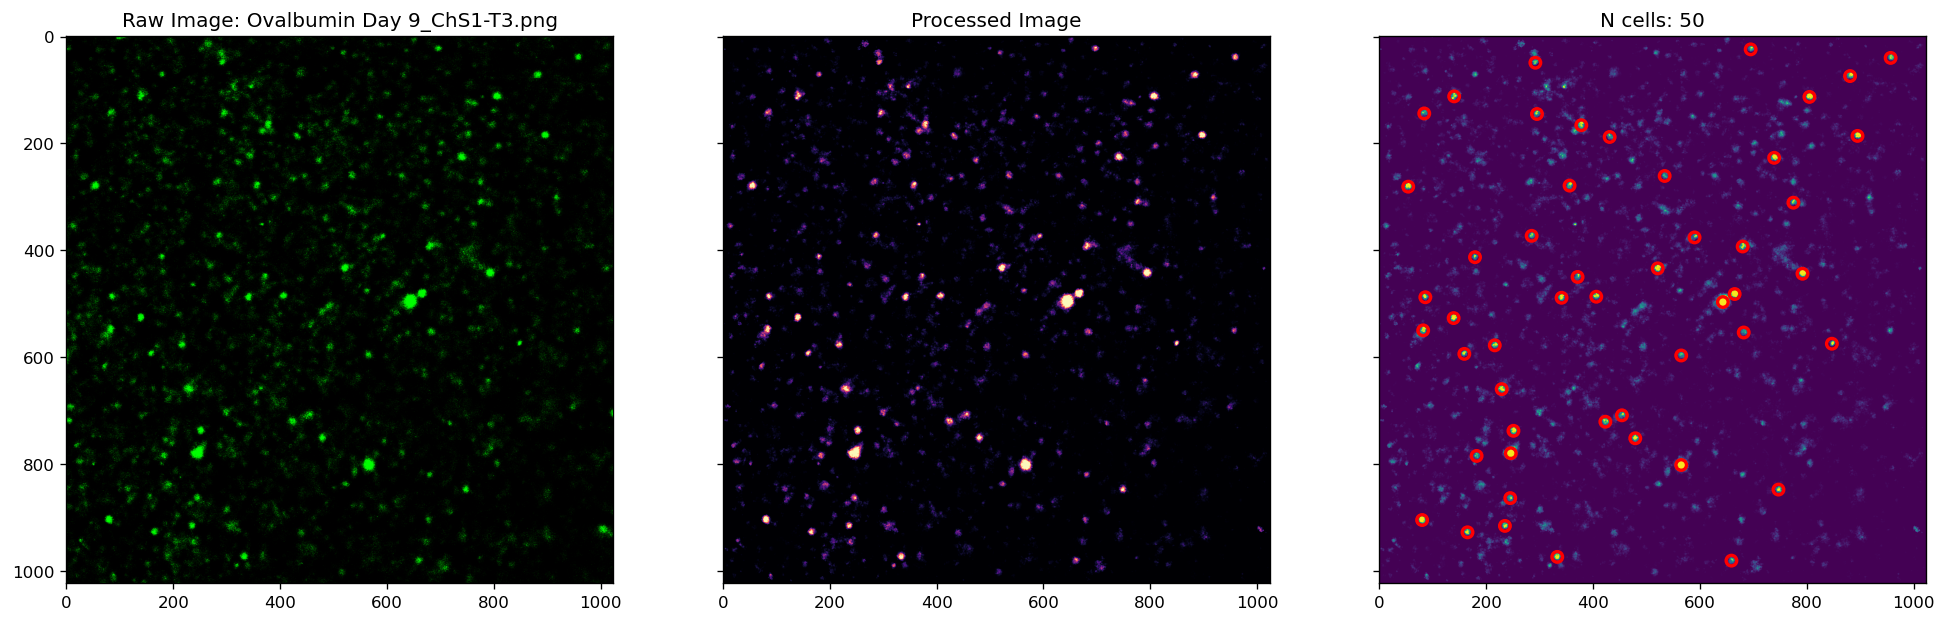

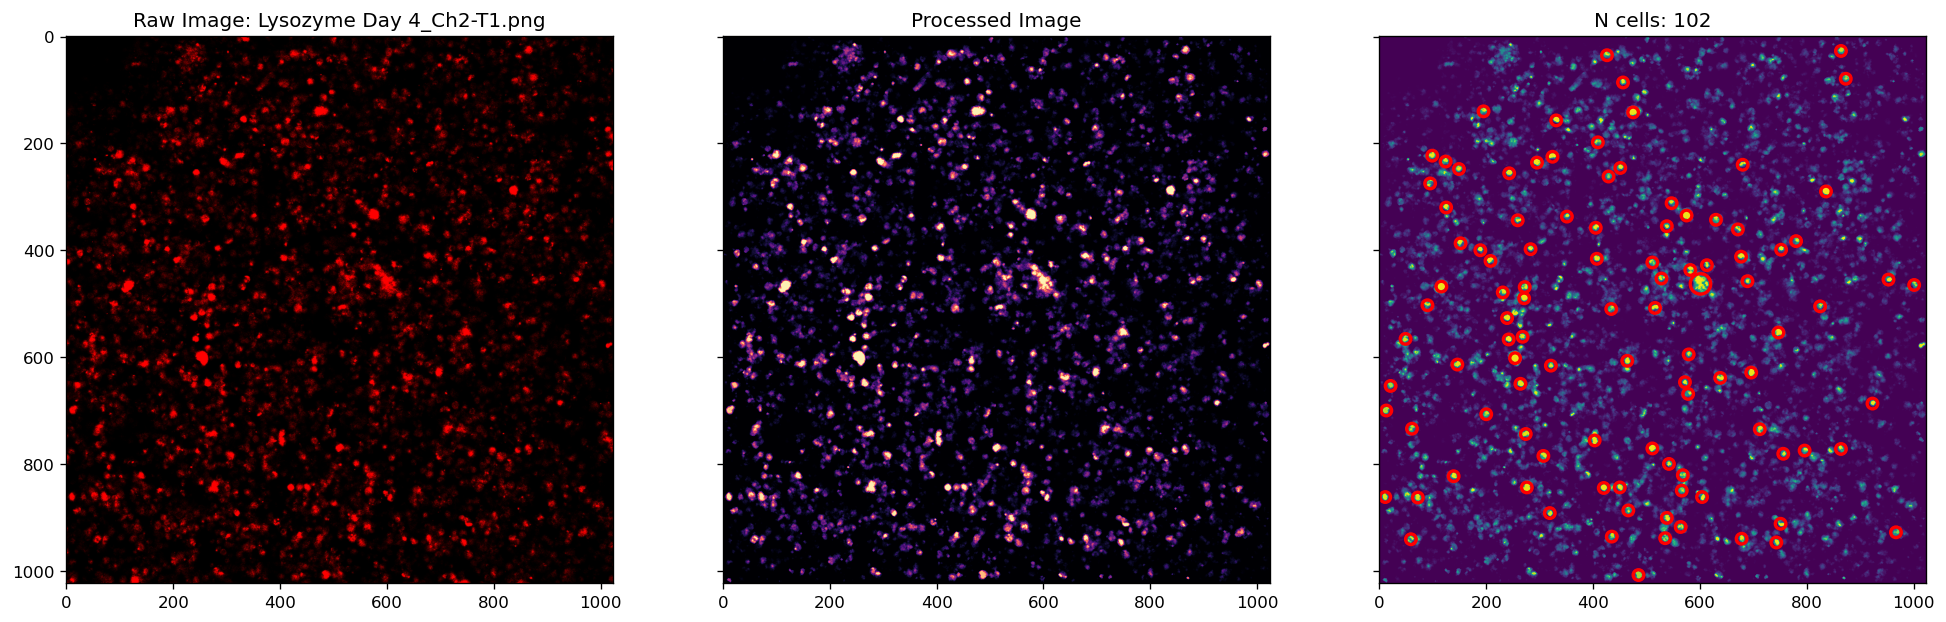

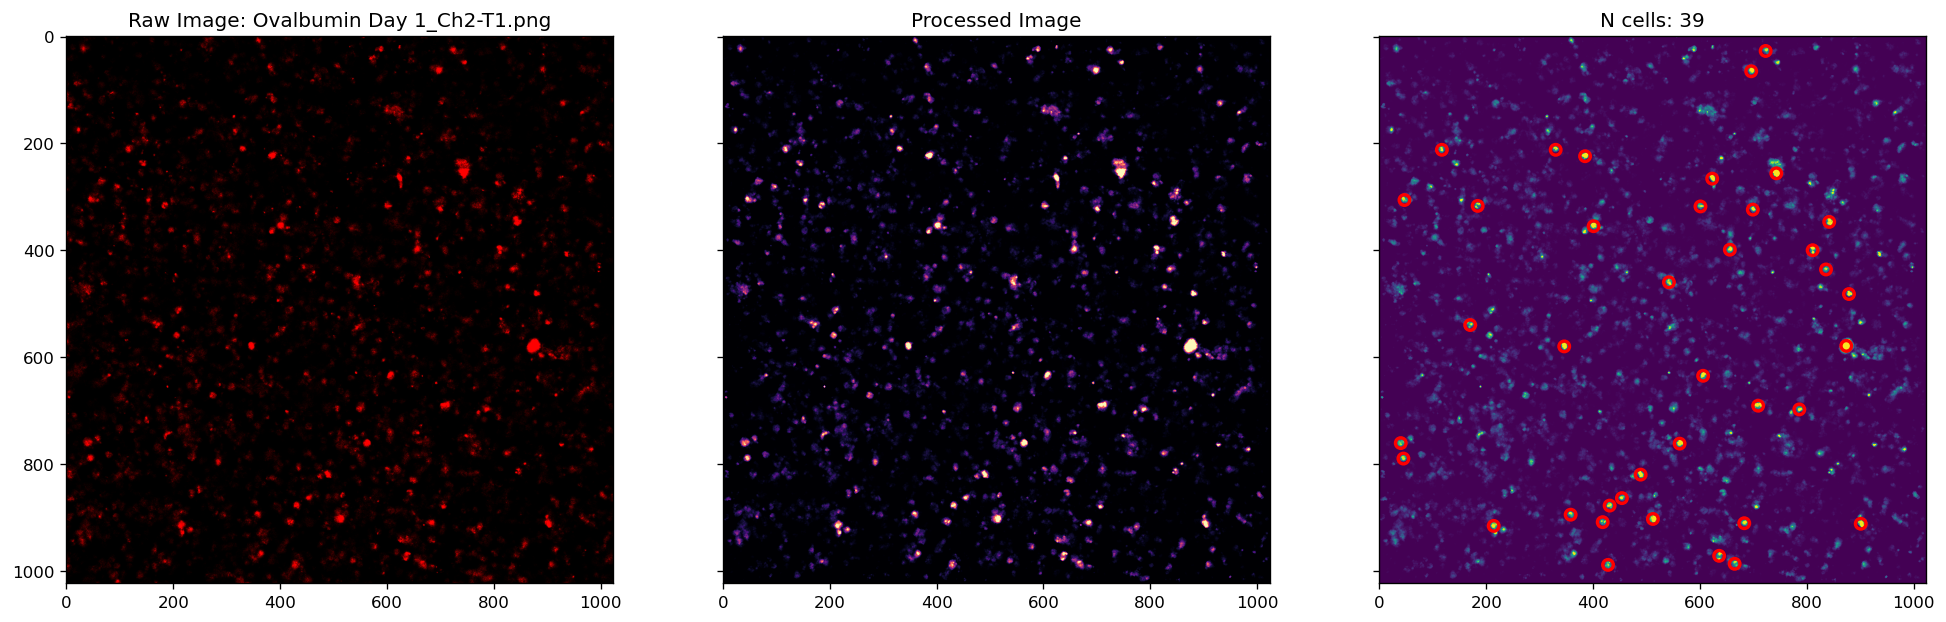

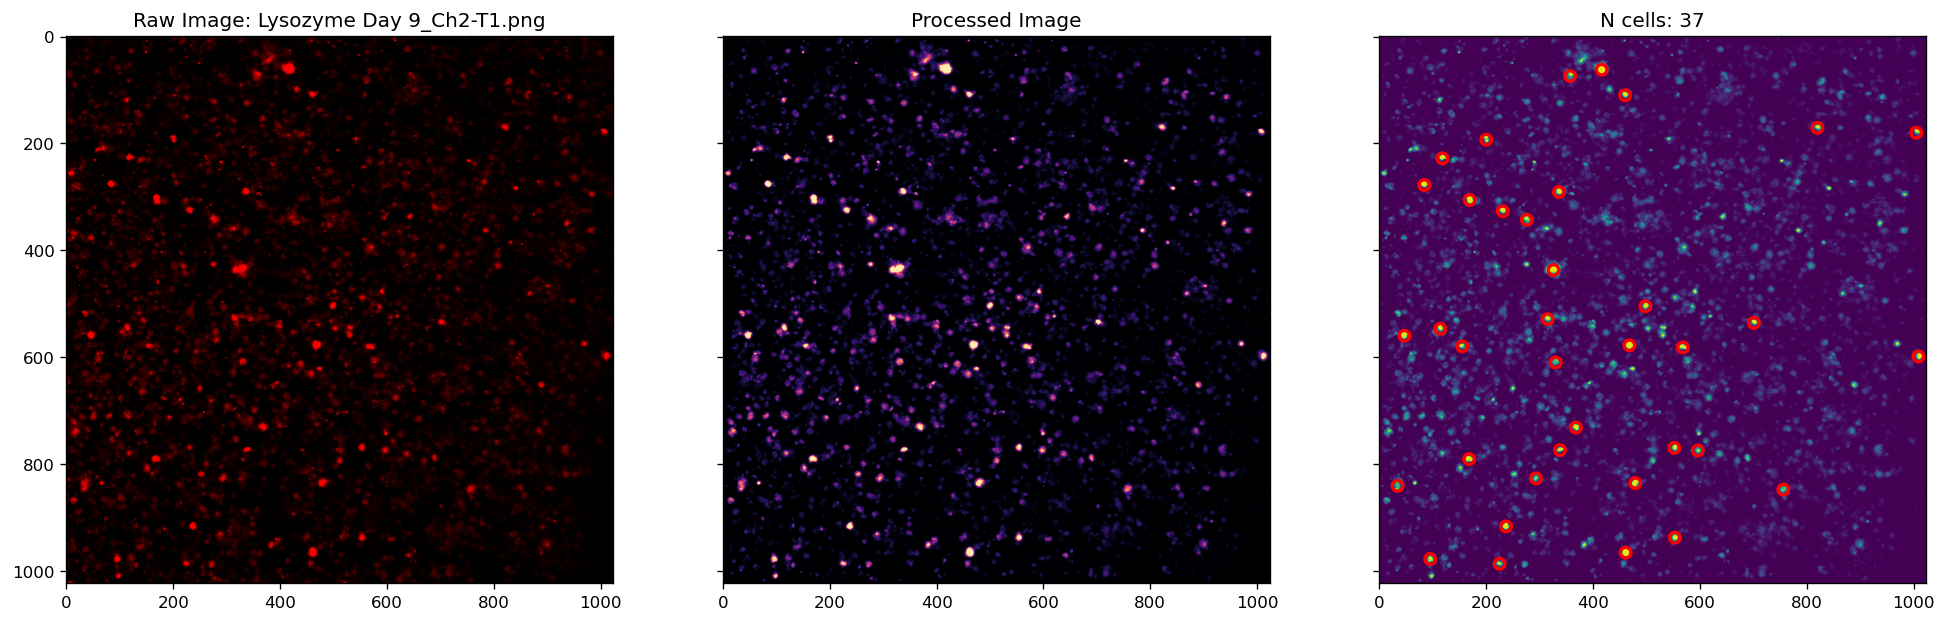

In [7]:
"""
plot a random image
"""

reload(_blob)
# test = exp.df[exp.df['channel'] == 'ChS2-T2']
# test = test[test['group'] == 'Ovalbumin']
# sample = test.sample(1)

sample = exp.df.sample(4)

for idx, row in sample.iterrows():
    _blob.plot_row(row, save=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


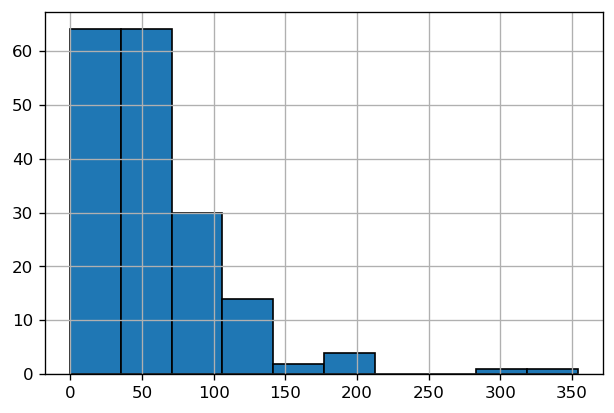

In [8]:
%time

def apply_get_LoG(row):
    img = _blob.preprocess_image(row['image'], row['channel'])
    return _blob.get_LoG_blobs(img, row['channel'])


exp.df['LoG_blobs']  = exp.df.apply(lambda x: apply_get_LoG(x), axis = 1)

# get counts
exp.df['n_blobs_count_1'] = exp.df['LoG_blobs'].apply(len)
exp.df['n_blobs_count_1'].hist(edgecolor='black')

In [9]:
# exp.df['n_blobs_count_1'].hist(edgecolor='black')
# plt.suptitle("Distribution of Estimated Cell Counts by Image")
# plt.savefig("figs/cell_count_histogram.png", bbox_inches='tight')

In [10]:
# sns.histplot(data=exp.df, x='n_blobs_count_1')

# plt.suptitle("Distribution of Estimated Cell Counts")
# plt.xlabel("N Images")
# plt.savefig("figs/cell_count_histogram.png", bbox_inches='tight')

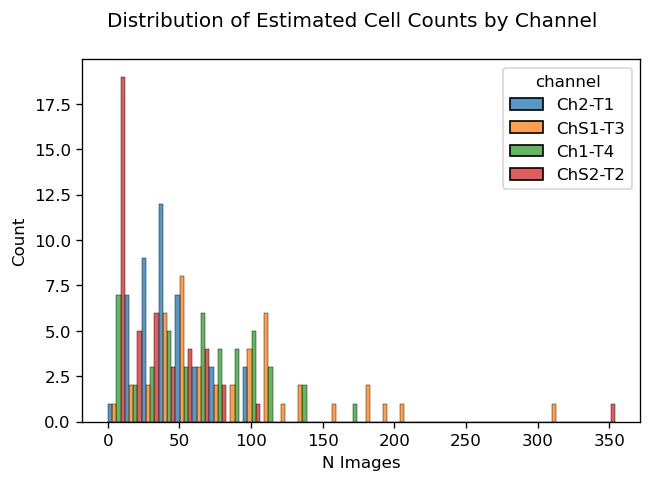

In [11]:
sns.histplot(x='n_blobs_count_1', data=exp.df, hue='channel', multiple="dodge",bins=30)
plt.xlabel("N Images")
plt.suptitle("Distribution of Estimated Cell Counts by Channel")
plt.savefig("figs/cell_count_histogram_by_channel.png", bbox_inches='tight')

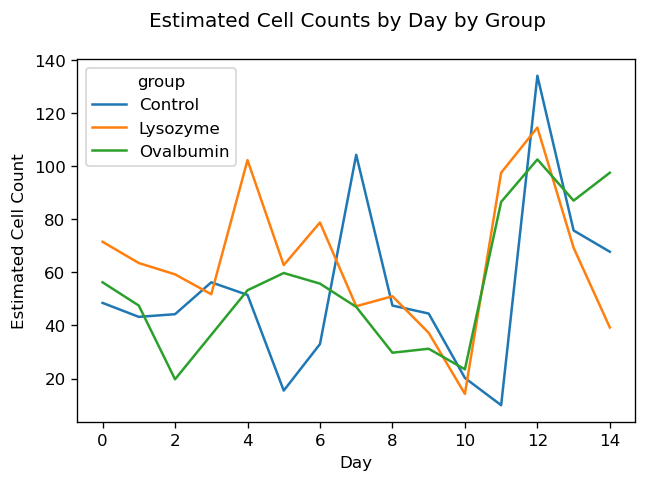

In [12]:
grouped_by_file = exp.df.groupby(['group', 'day'], as_index=False)['n_blobs_count_1'].mean()

sns.lineplot(x='day',
             y='n_blobs_count_1',
             hue='group',
             data=grouped_by_file)

plt.suptitle("Estimated Cell Counts by Day by Group")
plt.ylabel("Estimated Cell Count")
plt.xlabel("Day")
plt.savefig("figs/cell_count_by_day.png", bbox_inches='tight')

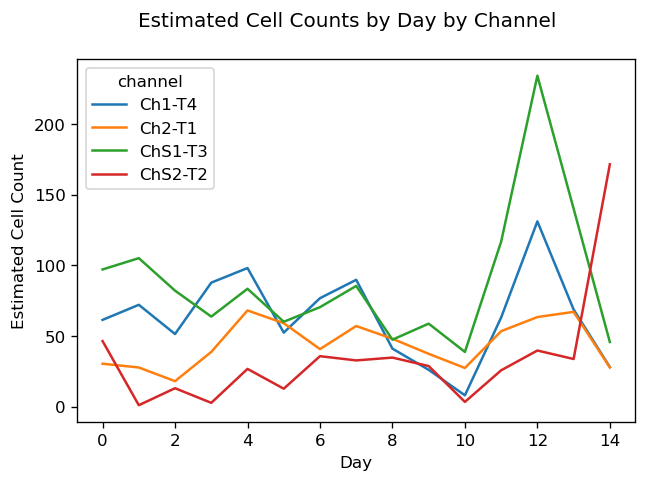

In [13]:
grouped_by_file = exp.df.groupby(['channel', 'day'], as_index=False)['n_blobs_count_1'].mean()

sns.lineplot(x='day',
             y='n_blobs_count_1',
             hue='channel',
             data=grouped_by_file)

plt.suptitle("Estimated Cell Counts by Day by Channel")
plt.ylabel("Estimated Cell Count")
plt.xlabel("Day")
plt.savefig("figs/cell_count_by_channel_day.png", bbox_inches='tight')

In [14]:
# exp.df.head()

Text(0.5, 1.0, 'Ovalbumin, day 1')

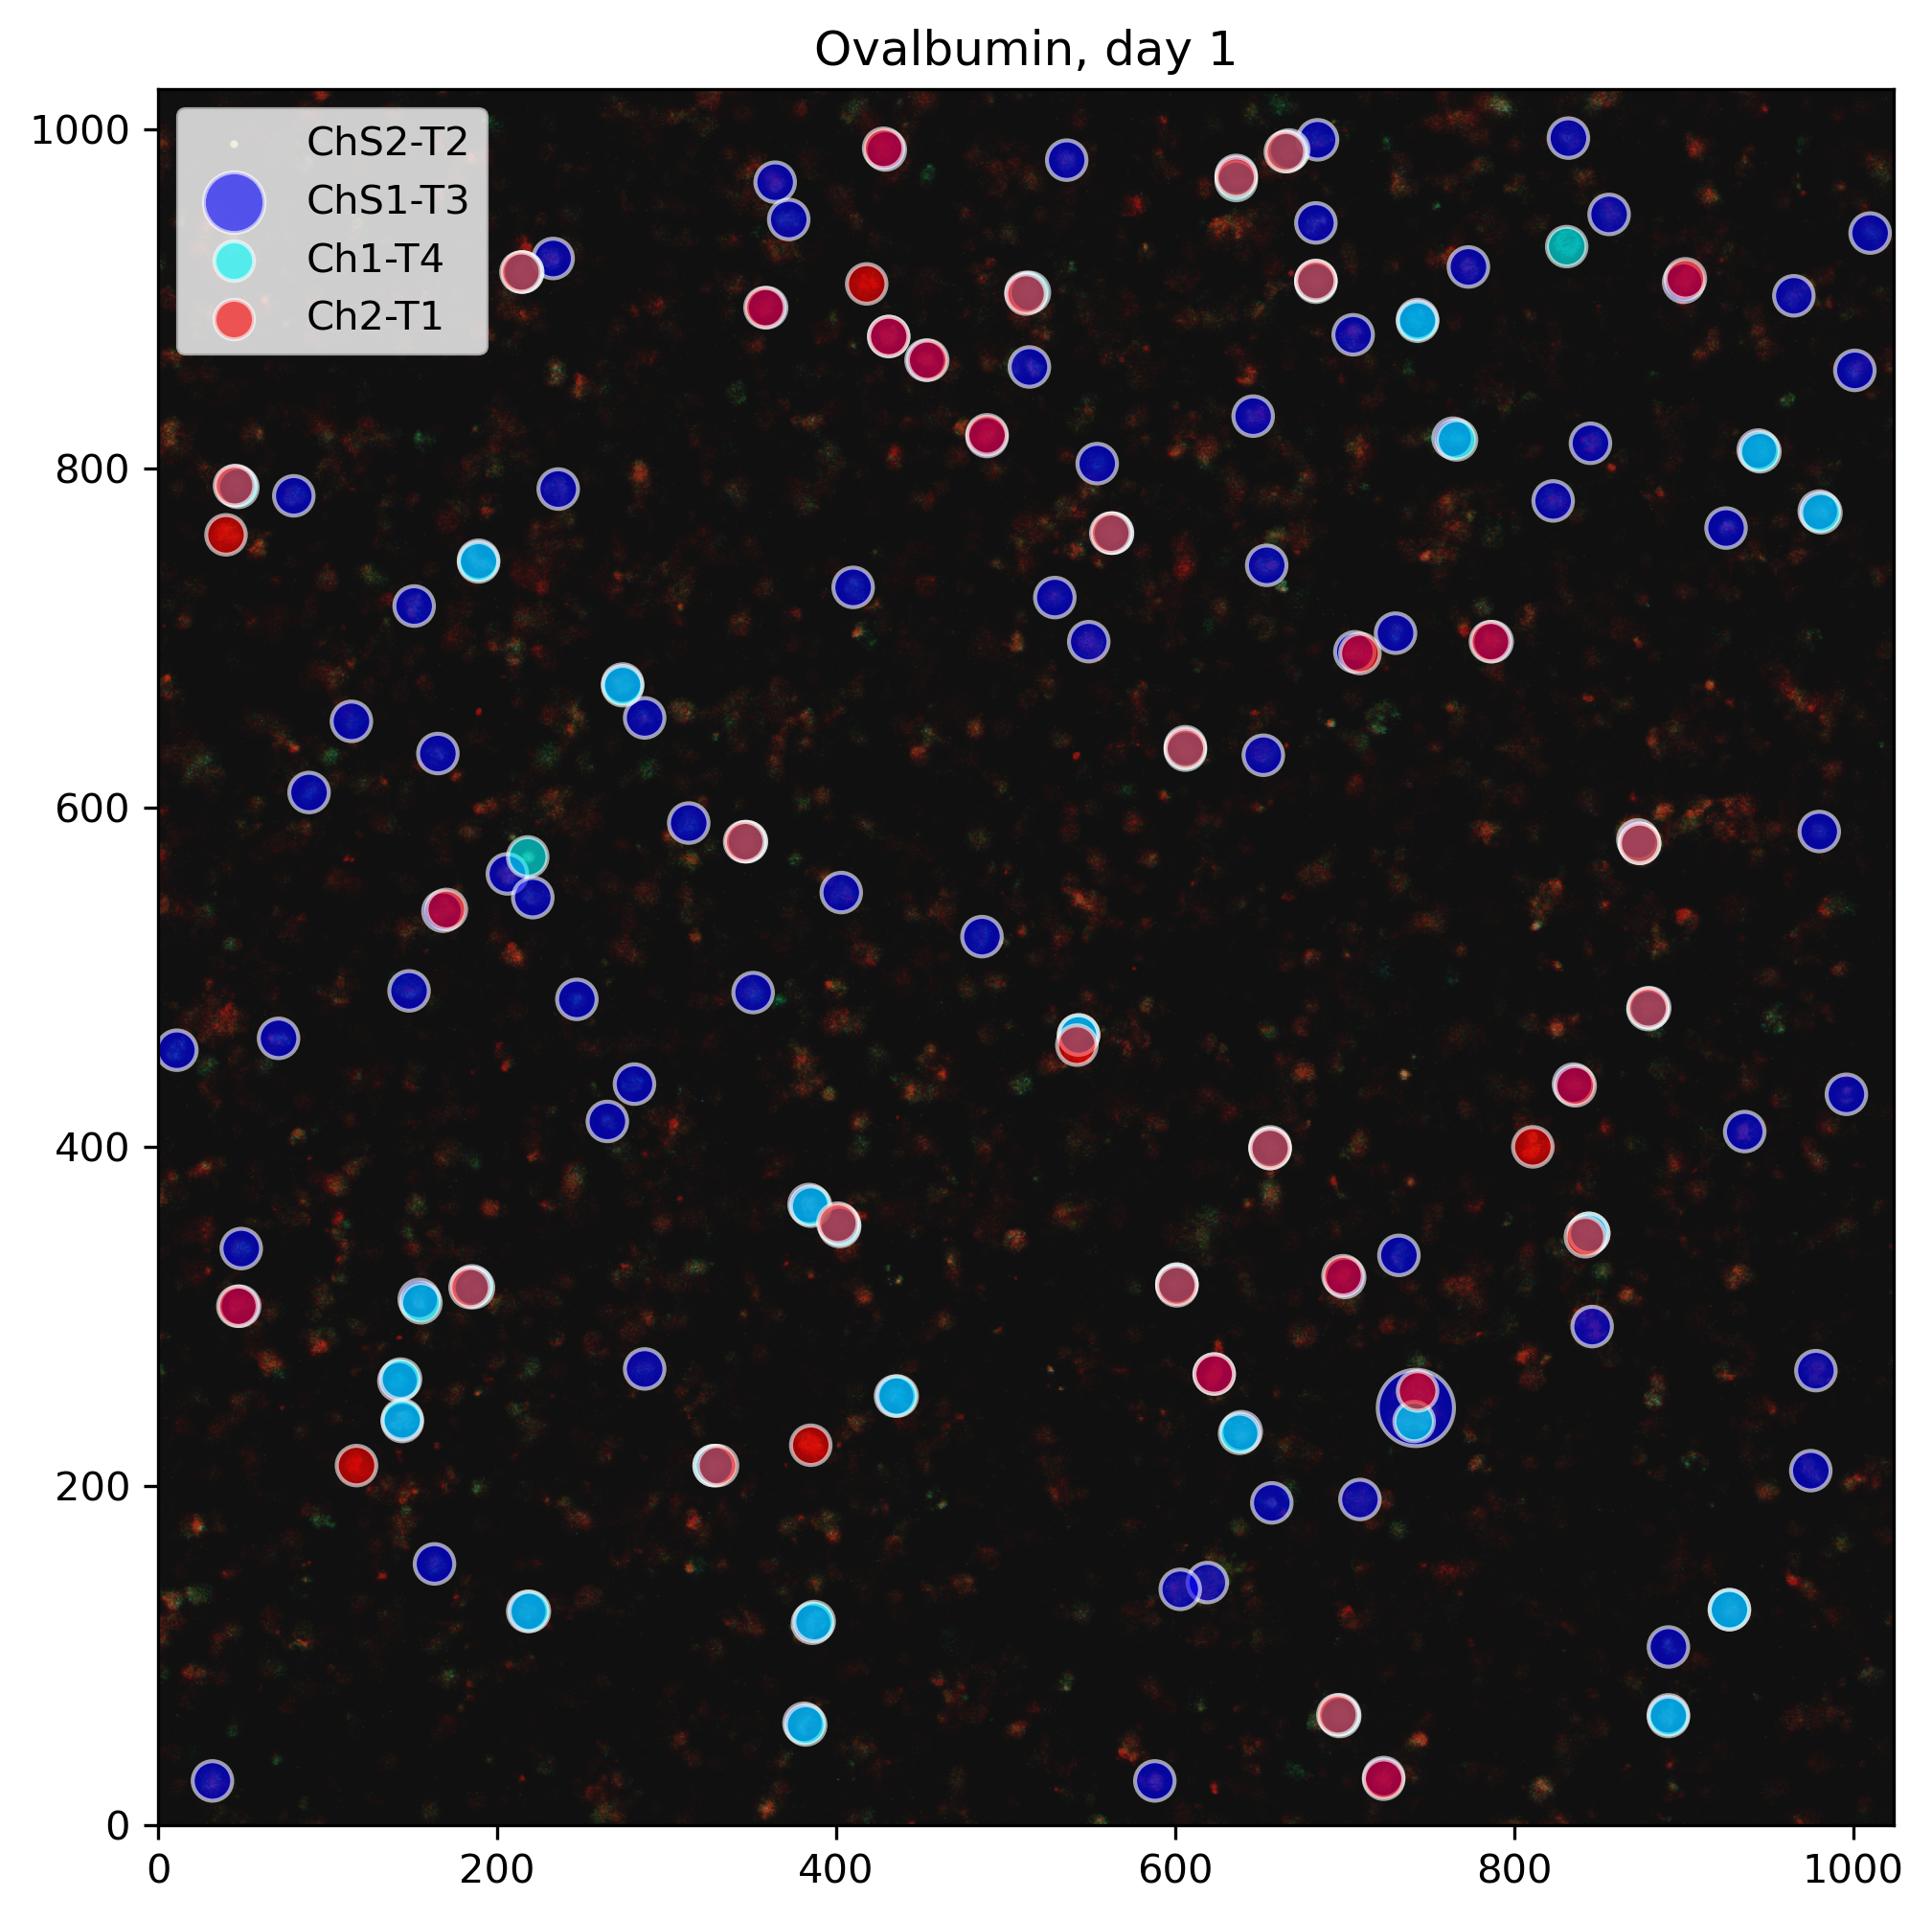

In [15]:
"""
start determining overlap
"""

rand_day = np.random.choice(exp.df['day'], 1)[0]
rand_group = np.random.choice(exp.df['group'], 1)[0]

group_subset = exp.df[(exp.df['day'] == rand_day) & (exp.df['group'] == rand_group)]

matplotlib.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim([0,1024])
ax.set_ylim([0,1024])

for idx, row in group_subset.iterrows():
    _color = row['channel_color']

    ax.imshow(row['image'], cmap='gray', alpha=0.5)

    ax.scatter(row['LoG_blobs'][:,1], 
               row['LoG_blobs'][:,0], 
               s=row['LoG_blobs'][:,2]**2, 
               marker='o', 
               edgecolor='white',
               alpha=0.6,
               color=_color,
               label=row['channel'])


plt.legend()
plt.title(f"{rand_group}, day {rand_day}")
# plt.savefig(f"figs/{rand_group} day {rand_day}_points.png", bbox_inches='tight')


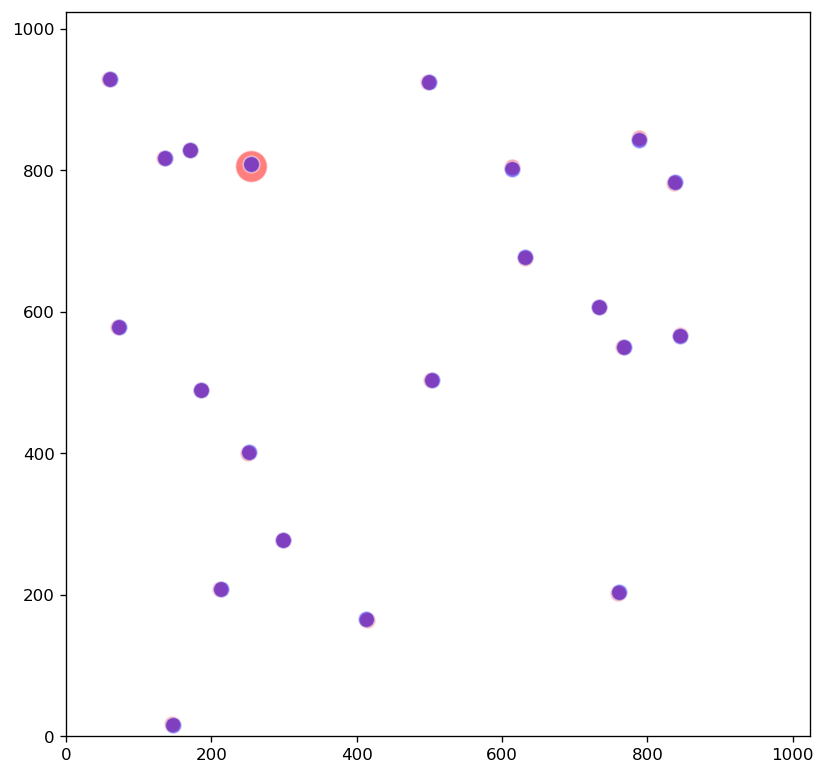

In [16]:
"""
plot overlap for a single day group
"""

reload(_blob)

rand_day = np.random.choice(exp.df['day'], 1)[0]
rand_group = np.random.choice(exp.df['group'], 1)[0]
group_subset = exp.df[(exp.df['day'] == rand_day) & (exp.df['group'] == rand_group)]


_blob.plot_overlap(group_subset, "red", "blue")      

In [82]:

rand_day = np.random.choice(exp.df['day'], 1)[0]
rand_group = np.random.choice(exp.df['group'], 1)[0]
group_subset = exp.df[(exp.df['day'] == rand_day) & (exp.df['group'] == rand_group)]


def blob_list_to_df(df):
    """ A utility function to covert nested colors to a single 
    dataframe
    
    args:
        : df (pd.DataFrame): with day group
        
    returns:
        blob_frame (pd.DataFrame): dataframe of blobs
    """
    df_list = []
    
    for color in df['channel_color']:
        mask = (df['channel_color'] == color)
        tmp_df = pd.DataFrame(df[mask]['LoG_blobs'].iloc[0])
        tmp_df[color] = 1
        tmp_df['cell_id'] = [f"{color}_{i+1}" for i in range(len(tmp_df)) ]
        df_list.append(tmp_df)

    df = pd.concat(df_list, ignore_index=True)
    df = df.rename(columns={0: 'y_coord', 
                            1: 'x_coord',
                            2: 'radius'})
    df['to_exclude'] = 0
    df = df.fillna(0)
    return df


def get_overlaps(blob_df, color1, color2, threshold):
    """ A function to assign new colors to a point if it overlaps 
    
    args:
        : blob_df (pd.DataFrame): a subset with detected blobs for each channel
        : color1 (str): color one
        : color2 (str):L color two
        : threshold (float): threshold for points considered close
    
    returns:
        : blob_df (pd.DataFrame): with new column indicating which cells
        are overlapping at the location
        : new_column_name (str): the new column name
    """
    new_column_name = f"{color1}_{color2}"
    
    color1_pts = blob_df[blob_df[color1] == 1].reset_index()
    color2_pts = blob_df[blob_df[color2] == 1].reset_index()

    # compute pairwise distances and 
    # determine close points
    dists = distance_matrix(color1_pts[['y_coord', 'x_coord']], 
                            color2_pts[['y_coord', 'x_coord']])
    
    close_points = np.argwhere((dists < threshold) & (dists != 0))
    
    # create the new column
    blob_df[new_column_name] = 0 
    
    # update new column
    for i, j in close_points:
        orig_c1_idx = color1_pts.iloc[i]['index']
        orig_c2_idx = color2_pts.iloc[j]['index']
        
        blob_df.at[orig_c1_idx, new_column_name] = 1
        blob_df.at[orig_c2_idx, new_column_name] = 1
        
        # flag the second cell as a cell to drop
        blob_df.at[orig_c2_idx, 'to_exclude'] = 1
    return blob_df, new_column_name
    

def apply_resolutions(row):
    """A function to apply resolutions """
    pass


def resolve_overlap(df, threshold=10):
    """A function to resolve overlapping cells from each of 4 channels 
    
    args:
        : df (pd.DataFrame): a subset with detected blobs for each channel

    returns:
        : cell_ids (dict): list of points for each lineage
    """
    # structure the blobs 
    blob_df = blob_list_to_df(df)
    
    # add all two-color combos
    color_combos = []
    for c1, c2 in list(combinations(df['channel_color'],2)):
        blob_df, new_col = get_overlaps(blob_df, c1, c2, threshold)
        color_combos.append(new_col)
        
        
    print(blob_df.shape) 
    # drop exclusions (the second cell in a pair of overlapping)
    blob_df = blob_df[blob_df['to_exclude'] == 0]
    print(blob_df.shape) 
    
  
    blob_df['sum_pairs'] = blob_df[color_combos].sum(axis=1)
    
    print(blob_df['sum_pairs'].value_counts())
    
    
    
    
  
 
    
    
    
    

    
    
resolve_overlap(group_subset)
    

    



(410, 15)
(228, 15)
0    103
1     82
2     28
3     15
Name: sum_pairs, dtype: int64


In [18]:


# def resolve_cell_color(dg):
#     """A function to return a list of cells for each color

#     arg:
#         : dg (pd.Dataframe): the control group and day for each channels
#     """

#     color_points = {
#         'red' : None,
#         'cyan' : None,
#         'blue' : None,
#         'yellow' : None,
#         'red_yellow' : None,
#         'red_blue' : None,
#         'red_cyan' : None,
#         'cyan_yellow' : None,
#         'cyan_blue' : None,
#         'blue_yellow' : None
#     }


#     blobs = []
#     for blob_list in dg.LoG_blobs:
#         blobs.append(np.asarray(blob_list))

#     blobs = np.concatenate(blobs, axis=0)
#     mean_radii = blobs[:, 2].mean()
#     threshold = mean_radii / np.sqrt(3)

#     dists = distance_matrix(blobs[:, 0:1], blobs[:, 0:1])

#     plt.imshow(dists)
    
#     # close_points = np.argwhere(dists < threshold)
#     # print(close_points)


    

    

#     # print(dg.channel_color)

#     # red_blobs = np.asarray(dg.loc[dg['channel_color'] == 'red', 'LoG_blobs'][0])
#     # blue_blobs = np.asarray(dg.loc[dg['channel_color'] == 'blue', 'LoG_blobs'][0])
#     # cyan_blobs = np.asarray(dg.loc[dg['channel_color'] == 'cyan', 'LoG_blobs'][0])
#     # yellow_blobs = np.asarray(dg.loc[dg['channel_color'] == 'yellow', 'LoG_blobs'][0])

#     # print(red_blobs.shape)



#     # tmp = np.asarray(dg['LoG_blobs'].tolist())
#     # print(tmp.shape)






# days = exp.df['day'].unique()
# group = exp.df['group'].unique()

# for d in days:
#     for g in group:
        
#         print("-----------")
#         print(f"{g} day {d}")

#         mask = (exp.df['day'] == d) & (exp.df['group'] == g)
#         day_group = exp.df[mask]

#         resolve_cell_color(day_group)



#         # for idx, row in day_group.iterrows():

#         #     blobs = np.asarray(row['LoG_blobs'])
#         #     mean_blob_radii = blobs[:, 2].mean()

#         #     print(row['channel_color'], blobs.shape, blobs[:, 2].mean())

#         break
#     break
